In [1]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import signal
from contextlib import contextmanager
import matplotlib.pyplot as plt


# Data Scraping

- import the urls from csv file
- use `requests` to check if the status code is 200
- for all good urls, scrape the text using Beautiful soup
- use basic NLP techniques to clean, tokenize, and stem the words 

In [2]:
#Collect urls from text file containing all URL sources
def collect_urls(text_file):
    urls = []
    with open(text_file) as file:
        for line in file:
            if "http" in line:
                urls.append('http' + line.split('http')[-1][:-2].replace(' ',''))
    return urls

#Some urls do not exist or take too long to load and halt the program ,
#so we implement a timer to skip bad urls and collect all urls that
#return a 200 code
@contextmanager
def timeout(time):
    # Register a function to raise a TimeoutError on the signal.
    signal.signal(signal.SIGALRM, raise_timeout)
    # Schedule the signal to be sent after ``time``.
    signal.alarm(time)

    try:
        yield
    except TimeoutError:
        pass
    finally:
        # Unregister the signal so it won't be triggered
        # if the timeout is not reached.
        signal.signal(signal.SIGALRM, signal.SIG_IGN)


def raise_timeout(signum, frame):
    raise TimeoutError


def check_status(url):
    # Add a timeout block.
    with timeout(5):
        try:
            html_page = requests.get(url)
            if html_page.status_code == 200:
                print(url)
                return url
        except:
            pass

In [3]:
#Collect the urls from the text file
urls = collect_urls('list_of_articles.txt')


In [4]:
#from the list of urls, collect good urls
urls_to_clean = []
for url in urls:
    if check_status(url):
        urls_to_clean.append(url)


http://www.theaustralian.com.au/in-depth/terror/failed-bids-for-living-safe-together-funding-awarded-money/news-story/8f2998c8d5257b70d307f015f2188b58
https://www.aclu.org/cases/aclu-v-department-homeland-security-foia-lawsuit-seeking-records-countering-violent-extremism
https://www.aclu.org/coalition-letter-obama-administration-countering-violent-extremism-cve-program
http://www.strokeassociation.org/STROKEORG/LifeAfterStroke/HealthyLivingAfterStroke/ManagingMedicines/Anti-Clotting-Agents-Explained_UCM_310452_Article.jsp#.Vj_Cxyvl3L8
https://www.adl.org/news/press-releases/adl-report-white-supremacist-murders-more-than-doubled-in-2017
https://www.adl.org/sites/default/files/documents/assets/pdf/combating-hate/Aryan-Circle-Report.pdf
https://www.adl.org/sites/default/files/documents/assets/pdf/combating-hate/CR_4499_WhiteSupremacist-Report_web_vff.pdf
http://www.aaiusa.org/countering_violent_extremism_cve
http://www.aph.gov.au/About_Parliament/Parliamentary_Departments/Parliamentary_Li

https://www.justice.gov/sites/default/files/usao-ma/pages/attachments/2015/02/18/framework.pdf
http://www.justice.gov/sites/default/files/jmd/pages/attachments/2015/02/02/7._state_and_local_fact_sheet.pdf
https://www.dhs.gov/community-engagement
http://www.dhs.gov/topic/countering-violent-extremism
https://www.dhs.gov/cve/task-force
http://www.dhs.gov/news/2016/01/08/countering-violent-extremism-task-force
https://www.dhs.gov/hometown-security
https://www.dhs.gov/cvegrants
https://www.dhs.gov/sites/default/files/publications/16_1028_S1_CVE_strategy.pdf
https://www.dhs.gov/sites/default/files/publications/Los%20Angeles%20Framework%20for%20CVE-Full%20Report.pdf
https://www.dhs.gov/news/2017/01/13/statement-secretary-jeh-johnson-announcing-first-round-dhss-countering-violent
http://www.dhs.gov/news/2015/09/28/statement-secretary-jeh-c-johnson-dhs%E2%80%99s-new-office-community-partnerships
http://www.dhs.gov/countering-violent-extremism-understanding-violent-extremism
https://www.dhs.gov/

In [5]:
#save list of good urls to a file
urls_df = pd.DataFrame(urls_to_clean)
urls_df.to_csv('good_urls_df.csv')

We are interested in analyzing the topics of an article, so we will create a list of articles that consist of tokens of stemmed words, using the `NLTK` stemming tool. We will remove stop words with `SpaCy`'s stopword collection. 

In [18]:
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer

articles =[]
i=0
for url in urls_to_clean:    
    try:
        html_page = requests.get(url)
        soup = BeautifulSoup(html_page.text, 'html.parser')
        article_text = []
        for x in soup.find_all('p'):
            txt = x.get_text()
            if txt:
                txt = re.sub(r"[^a-zA-Z0-9]", " ", txt.lower())
                words = txt.split() #words withhin a paragraph
                words = [w for w in words if w not in list(STOP_WORDS)] # Remove stopwords
                words = [PorterStemmer().stem(w) for w in words] # stem
                for word in words:
                    if len(word)>2: #only useful words added
                        article_text.append(word)
        articles.append(article_text)
    except:
        print('{} was a bad article'.format(url))
    if i%10==0:
        print(i,'th url parsed')
    i+=1        

0 th url parsed
10 th url parsed
20 th url parsed
30 th url parsed
40 th url parsed
50 th url parsed
60 th url parsed
70 th url parsed
80 th url parsed
90 th url parsed
100 th url parsed


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/bs4/builder/_htmlparser.py:102: UserWarning: expected name token at '<![���+�\x04����qs\\=�\x10\x06'
  warnings.warn(msg)


http://www.gao.gov/assets/650/649616.pdf was a bad article
110 th url parsed
120 th url parsed


In [19]:
i=0
for article in articles:
    if len(article) < 4:
        articles.remove(article)
        i+=1
print('Removed {} redundant articles, we now have {} articles to model.'.format(i,len(articles)))

Removed 17 redundant articles, we now have 103 articles to model.


## Using Bigrams for Topic Modeling

Phrases and bigrams are helpful NLP tools offered in the `gensim` library that aid in topic modeling. For a given list of topics, we can feed it to a a Phraser and it will return word phrases (for example, the words "law" and "enforcement" are typically part of a phrase, so the phraser will return a new word "law_enforcement").

In [20]:
from gensim.models.phrases import Phrases, Phraser
phrases = Phrases(articles, min_count=1, threshold=2)
bigram = Phraser(phrases)
#here's an example of a bigram thhat we capture from the 4th article
bigram[articles[3]]

['new_york',
 'januari',
 '2018',
 'number_white',
 'supremacist',
 'murder',
 'unit_state',
 'doubl',
 '2017',
 'compar_previou',
 'year',
 'far',
 'surpass',
 'murder',
 'commit',
 'domest',
 'islam_extremist',
 'make',
 '2017',
 'fifth',
 'deadliest',
 'year',
 'record',
 'extremist_violenc',
 '1970',
 'annual',
 'assess_extremist',
 'relat_kill',
 'anti_defam',
 'leagu',
 'center_extrem',
 'found_white',
 'supremacist',
 'far_right',
 'extremist',
 'respons',
 'percent',
 'extremist_relat',
 'fatal',
 '2017',
 'dramat',
 'percent',
 '2016',
 'white_supremacist',
 'directli',
 'respons',
 'total',
 'extremist_relat',
 'murder_2017',
 'accord',
 'new',
 'adl',
 'report',
 'murder_extrem',
 'unit_state',
 '2017',
 'total',
 'death',
 'link_islam',
 'extremist_recent',
 'adl',
 'data',
 'show',
 'decad',
 'total',
 'percent',
 'fatal',
 'link',
 'domest_right',
 'wing_extremist',
 'percent',
 'kill',
 'commit',
 'islam_extremist',
 'percent',
 'death',
 'carri',
 'extremist_fall',
 'ca

In [21]:
#lets collect all of our bigrams into a list for each article:

bigram_articles = []
for article in bigram[articles]:
    bigram_articles.append(article)

## Creating a word dictionary

From our list of bigrams, we will create a word frequency dictionary that we will use to find the topic of the articles.

In [24]:
#turn our list of lists into a single list of bigrams
list_of_bigrams = []
for article in bigram_articles:
    for word in article:
        if (not word=='jump_navig') & (not word =='skip_navig'):
            list_of_bigrams.append(word)

In [26]:
from collections import defaultdict
#Get a word dictonary from our list of bigrams
def word_freq(article):
    word_f = defaultdict(int)
    for word in article:
        word_f[word] += 1
    return word_f


## Topic Modeling using Bigram Frequency

The topic of the article will be assigned to the top 5 bigrams the article contains. 

In [27]:
#topic per article
bigram_topics = []
for article in bigram_articles: 
    #print("\n Topic of paragraph : ")
    wf = word_freq(article)
    wf_sorted = sorted(wf.items(), key=lambda x: x[1], reverse=True)
    bigram_topics.append(' '.join(list(dict(wf_sorted[:5]).keys())))

In [32]:
#list of all topic words in all articles    
topic_words = {}
topic_lists = [x.split(' ') for x in bigram_topics]
for topic in topic_lists:
    for word in topic:
        if word in topic_words.keys():
            topic_words[word]+=1
        else:
            topic_words[word]=1
sorted_topic_words = sorted(topic_words.items(), key=lambda x: x[1], reverse=True)
sorted_topic_words.remove(('', 8))




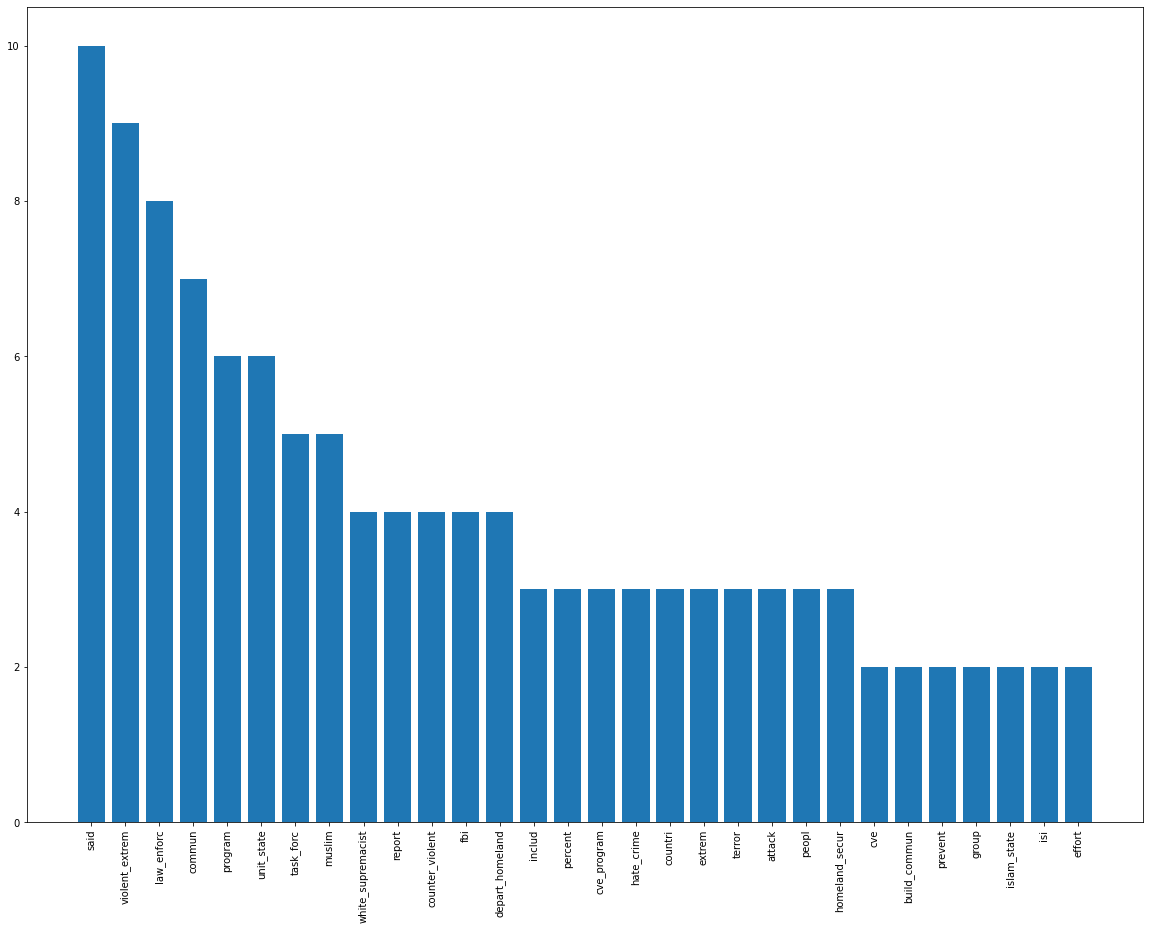

In [35]:
to_plt = dict(sorted_topic_words[:30])
plt.figure(figsize=(20,15))
plt.bar(range(len(to_plt)), list(to_plt.values()), align='center')
plt.xticks(range(len(to_plt)), list(to_plt.keys()), rotation='vertical')

plt.show()

In [36]:
bigram_topics

['inform american_muslim program includ aclu',
 'jump_navig skip_navig',
 'stroke warfarin american_heart aspirin heart',
 'adl 2017 percent white_supremacist anti_defam',
 'commun cve report cve_program civil_right',
 'violent_extrem 2011 000_2012 grant_regist build_commun',
 'counter_terror foreign_fighter strateg_plan terror_threat terrorist_attack',
 'prevent school signific_sourc independ_review programm',
 'said program reject commun group',
 'islam_state isi arab daesh french',
 'isi fighter month coalit cash',
 'chariti islam_chariti bank_unit state iara',
 'counter_violent effort task_forc new_task stephani_condon',
 'isil fbi threat social_media individu',
 'american republican syrian_refuge prri roughli',
 'paddock gunman thursday offic vega_review',
 'fbi law_enforc commun cveo radic',
 'hate_crime crime report incid victim_crime',
 'fbi terrorist_organ intern_terror violent_crimin act_commit',
 'gang task_forc investig safe_street law_enforc',
 'notic_fund nonprofit_secur 